In [781]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
import plotly.express as px
import json
import numpy as np
from sklearn.neighbors import BallTree
import folium
from sklearn.metrics.pairwise import haversine_distances

In [782]:
# macOS 기본 한글 폰트 설정 (AppleSDGothicNeo 등)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [783]:
path = '/Users/yniyunj/Desktop/교육공공데이터/데이터/002-전출입생수/'

df_24 = pd.read_csv(path + '2024년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_23 = pd.read_csv(path + '2023년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_22 = pd.read_csv(path + '2022년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_21 = pd.read_csv(path + '2021년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_20 = pd.read_csv(path + '2020년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_19 = pd.read_csv(path + '2019년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_18 = pd.read_csv(path + '2018년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_17 = pd.read_csv(path + '2017년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_16 = pd.read_csv(path + '2016년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_15 = pd.read_csv(path + '2015년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')

# 데이터 전처리

- 2025년도의 각 학교 SCR index 값은??

## 1.1 해당 학교 학생수 감소율 ($S_i$)

- 3년간 연평균 학생수 감소율의 평균
- 단기적으로 학교 규모 축소의 빠르기를 계산   

- $S_i = \frac{1}{3} \sum_{k=1}^3 \frac{총학생수_{k년전} - 총학생수_{k-1년전}}{총학생수_{k년전}}$

In [784]:
df_21.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 전입학생수', '1학년 전출학생수', '1학년 전체학생수', '2학년 전입학생수', '2학년 전출학생수',
       '2학년 전체학생수', '3학년 전입학생수', '3학년 전출학생수', '3학년 전체학생수', '4학년 전입학생수',
       '4학년 전출학생수', '4학년 전체학생수', '5학년 전입학생수', '5학년 전출학생수', '5학년 전체학생수',
       '6학년 전입학생수', '6학년 전출학생수', '6학년 전체 학생수', '전입학생수(계)', '전출학생수(계)',
       '전체학생수(계)'],
      dtype='object')

In [785]:
# 1. 연도별 필요한 컬럼 추출 (학교코드 + 총학생수만)
df_21_1 = df_21[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2021'})
df_22_1 = df_22[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2022'})
df_23_1 = df_23[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2023'})
df_24_1 = df_24[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2024'})

# 2. 병합 (학교코드 기준)
df_merge_1 = df_21_1.merge(df_22_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_23_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_24_1, on='정보공시 학교코드', how='inner')

# 3. S_i 계산 (결측치 제외하고 평균)
def calculate_S_i(row):
    ratios = []

    # student_2021 → student_2022
    if pd.notnull(row['student_2021']) and pd.notnull(row['student_2022']) and row['student_2021'] != 0:
        ratios.append((row['student_2021'] - row['student_2022']) / row['student_2021'])

    # student_2022 → student_2023
    if pd.notnull(row['student_2022']) and pd.notnull(row['student_2023']) and row['student_2022'] != 0:
        ratios.append((row['student_2022'] - row['student_2023']) / row['student_2022'])

    # student_2023 → student_2024
    if pd.notnull(row['student_2023']) and pd.notnull(row['student_2024']) and row['student_2023'] != 0:
        ratios.append((row['student_2023'] - row['student_2024']) / row['student_2023'])

    if ratios:
        return sum(ratios) / len(ratios)
    else:
        return np.nan

df_merge_1['S_i(2025)'] = df_merge_1.apply(calculate_S_i, axis=1)

# 4. 결과 추출
df_result_1 = df_merge_1[['정보공시 학교코드', 'S_i(2025)']]

df_result_1 = df_result_1.merge(df_24[['정보공시 학교코드', '학교명', '지역']], on='정보공시 학교코드', how='left')
df_result_1 = df_result_1[['정보공시 학교코드', '지역', '학교명', 'S_i(2025)']]
df_result_1 = df_result_1[df_result_1['지역'].fillna('').str.startswith('충청북도')]

df_result_1 = df_result_1[['지역', '학교명', 'S_i(2025)']].copy()
df_result_1['지역'] = df_result_1['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_1.to_csv(path+'/SCR_data/1-S_i(2025).csv', index=False)
df_result_1

,지역,학교명,S_i(2025)
3571,충청북도 청주시,청주교육대학교부설초등학교,0.030908
3572,충청북도 청주시,한국교원대학교부설월곡초등학교,0.057903
3573,충청북도 괴산군,감물초등학교,-0.057043
3574,충청북도 괴산군,괴산명덕초등학교,0.121450
3575,충청북도 증평군,도안초등학교,-0.190013
...,...,...,...
3830,충청북도 충주시,충주중앙탑초등학교,-0.066565
3831,충청북도 청주시,생명초등학교,-0.180814
3832,충청북도 충주시,충주대소원초등학교,-0.105675
3833,충청북도 충주시,충주남한강초등학교,-0.100296


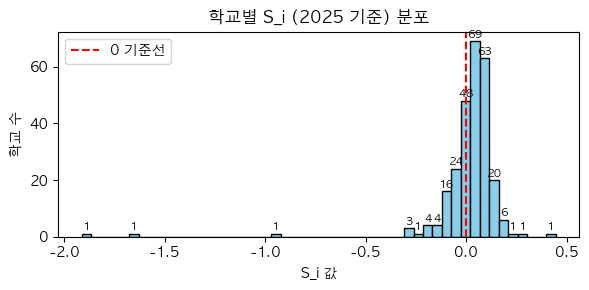

In [786]:
# inf, -inf, NaN 제거
data = df_result_1['S_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 3))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 S_i (2025 기준) 분포")
plt.xlabel("S_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

## 1.2 해당 학교 전출입 증가율 ($T_i$)

- 3년간 연평균 전출 증가율의 평균
- 학생들이 해당 학교를 떠나는 흐름이 가속화되는지 계산   

- $T_i = \frac{1}{3} \sum_{k=1}^3 \frac{전출수_{k년전} - 전입수_{k년전}}{총학생수_{k년전}}$

In [787]:
# 필요한 열만 추출
cols = ['정보공시 학교코드', '지역', '학교명', '전입학생수(계)', '전출학생수(계)', '전체학생수(계)']

# 필요한 연도 데이터 정제
df_22_2 = df_22[cols].copy()
df_23_2 = df_23[cols].copy()
df_24_2 = df_24[cols].copy()

# 연도 정보 추가
df_22_2['year'] = 2022
df_23_2['year'] = 2023
df_24_2['year'] = 2024

# 통합
df_all = pd.concat([df_22_2, df_23_2, df_24_2])

# 계산식: (전출 - 전입) / 전체학생수
# 전체학생수(계)가 0이면 결과를 0으로 설정
T_i_values = []
for idx, row in df_all.iterrows():
    if row['전체학생수(계)'] == 0:
        T_i_values.append(0)
    else:
        T_i_values.append((row['전출학생수(계)'] - row['전입학생수(계)']) / row['전체학생수(계)'])

# ✅ 결과를 새로운 열로 추가
df_all['T_i (2025)'] = T_i_values

# 학교별 평균 계산
df_result_2 = df_all.groupby(['정보공시 학교코드', '지역', '학교명'])['T_i (2025)'].mean().reset_index()
df_result_2 = df_result_2[df_result_2['지역'].fillna('').str.startswith('충청북도')]

df_result_2 = df_result_2[['지역', '학교명', 'T_i (2025)']].copy()
df_result_2['지역'] = df_result_2['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_2.to_csv(path+'/SCR_data/2-T_i(2025).csv', index=False)
df_result_2

,지역,학교명,T_i (2025)
9,충청북도 청주시,청주교육대학교부설초등학교,0.006705
10,충청북도 청주시,한국교원대학교부설월곡초등학교,0.006550
3645,충청북도 괴산군,감물초등학교,-0.061153
3646,충청북도 괴산군,괴산명덕초등학교,0.040922
3647,충청북도 증평군,도안초등학교,-0.005400
...,...,...,...
3906,충청북도 충주시,충주남한강초등학교,-0.022180
3907,충청북도 청주시,용아초등학교,-0.099035
3908,충청북도 충주시,용원초등학교동락분교장,0.166667
3909,충청북도 단양군,영춘초등학교별방분교장,0.122222


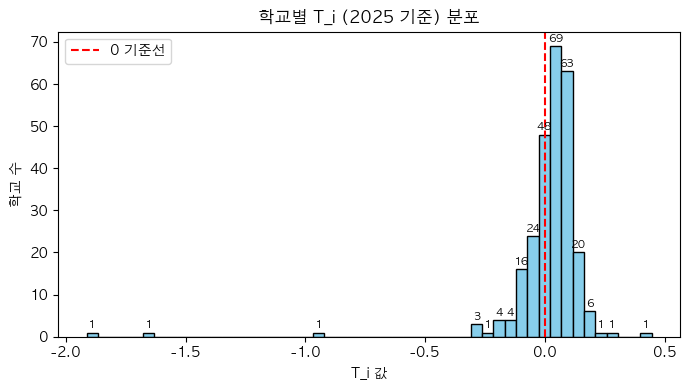

In [788]:
plt.figure(figsize=(7, 4))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 T_i (2025 기준) 분포")
plt.xlabel("T_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

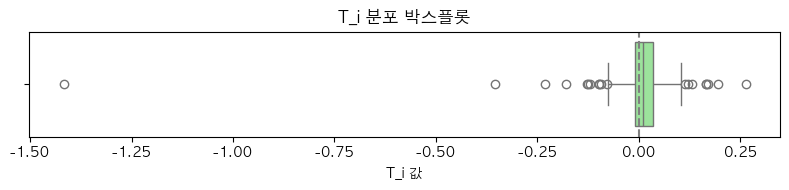

In [789]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_result_2['T_i (2025)'], color='lightgreen')
plt.axvline(0, color='gray', linestyle='--')
plt.title("T_i 분포 박스플롯")
plt.xlabel("T_i 값")
plt.tight_layout()
plt.show()

## 1.3 해당 통학구역 신생아수 감소율 ($B_i$)

- 7년간 연평균 신생아수 감소율의 평균 (2020~ 데이터만 존재해서 총 5년(2020-2024) 데이터 사용함)
- 해당 지역의 미래 학령인구 기반이 약화되고 있는 정도   

- $B_i = \frac{1}{7} \sum_{k=1}^7 \frac{신생아수_{k년전} - 신생아수_{k-1년전}}{신생아수_{k년전}}$

In [790]:
df_baby = pd.read_csv(path + '장래_인구변동요인_출생__사망__인구이동_등__20250426125222.csv')
df_baby

,행정구역별(1),2020,2020.1,2020.2,2021,2021.1,2021.2,2022,2022.1,2022.2,2023,2023.1,2023.2,2024,2024.1,2024.2
0,행정구역별(1),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당)
1,충청북도,1630839,8952,5.5,1632358,8683,5.3,1633687,8375,5.1,1635672,7994,4.9,1637564,8022,4.9
2,청주시,855530,5379,6.3,859652,5319,6.2,861345,5171,6.0,864352,4962,5.7,866741,5000,5.8
3,충주시,216776,1104,5.1,216608,1010,4.7,215972,933,4.3,215787,891,4.1,215637,896,4.2
4,제천시,134741,614,4.6,133885,568,4.2,133755,518,3.9,133210,492,3.7,132610,492,3.7
5,보은군,31666,95,3.0,31369,81,2.6,31179,84,2.7,31016,77,2.5,30926,74,2.4
6,옥천군,48985,168,3.4,48671,145,3.0,48452,127,2.6,48471,118,2.4,48514,115,2.4
7,영동군,47171,195,4.1,46114,152,3.3,45397,132,2.9,44808,121,2.7,44415,119,2.7
8,증평군,37298,205,5.5,36720,225,6.1,37353,251,6.7,37739,243,6.4,37991,245,6.4
9,진천군,89694,596,6.6,92721,590,6.4,93826,575,6.1,94775,548,5.8,95828,550,5.7


In [791]:
# ✅ 필요한 컬럼만 선택
cols = ['행정구역별(1)', '2020.2', '2021.2', '2022.2', '2023.2', '2024.2']
df_selected = df_baby[cols]
df_selected = df_selected.iloc[1:].reset_index(drop=True)

for col in ['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']:
    df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')

df_selected['B_i(2025)'] = df_selected[['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']].mean(axis=1).round(2)
df_result_3 = df_selected.rename(columns={'행정구역별(1)': '행정구역'})

df_result_3 = df_result_3[['행정구역', 'B_i(2025)']]
df_result_3

,행정구역,B_i(2025)
0,충청북도,5.14
1,청주시,6.00
2,충주시,4.48
3,제천시,4.02
4,보은군,2.64
5,옥천군,2.76
6,영동군,3.14
7,증평군,6.22
8,진천군,6.12
9,괴산군,1.88


In [792]:
df_result_3.to_csv(path + 'SCR_data/3-B_i(2025).csv')

## 1.4 인접학교 밀집도 ($D_i$)

- 폐교해도 대체가 가능한지 보여주는 지표
- 밀집도가 높을수록 전출 가능성↑, 폐교 용이성↑   

- $D_i = 반경 R km 이내의 초등학교 수$

In [793]:
df_24_schools = pd.read_csv(path + '250425-충청북도_학교별_주소_new위도_new경도.csv')
df_24_schools

,Unnamed: 0,학교명,학교도로명 주소,폐교여부,new위도,new경도
0,0,청주교육대학교부설초등학교,충청북도 청주시 서원구 청남로 2067,N,36.617245,127.484741
1,1,한국교원대학교부설월곡초등학교,충청북도 청주시 흥덕구 강내면 가로수로 562,N,36.622385,127.362822
2,2,감물초등학교,충청북도 괴산군 감물면 남양동길 38,N,36.839123,127.871318
3,3,괴산명덕초등학교,충청북도 괴산군 괴산읍 읍내로4길 53,N,36.809356,127.787067
4,4,도안초등학교,충청북도 증평군 도안면 화성로 101,N,36.817063,127.611156
...,...,...,...,...,...,...
292,292,충주남한강초등학교,충청북도 충주시 호암수청2로 55,N,36.955144,127.929240
293,293,용아초등학교,충청북도 청주시 상당구 중고개로142번길 32-15,N,36.618252,127.522719
294,294,용원초등학교동락분교장,충청북도 충주시 신니면 신덕로 301,N,37.003450,127.686138
295,295,영춘초등학교별방분교장,충청북도 단양군 영춘면 별방창원로 449,N,37.096357,128.415812


### 가장 가까운 학교 간 평균거리 계산

- 폐교된 학교를 제외한 학교들
- 가장 가까운 학교 간 평균거리 계산
- 행정구역 단위로 계산 (행정구역 간의 편차가 크기 때문)

In [794]:
# 1. 운영 중인 학교만 필터링
df_active = df_24_schools[df_24_schools['폐교여부'] == 'N'].reset_index(drop=True)

# 2. '행정구역' 컬럼 생성 (학교도로명 주소를 스페이스로 분리 → 두 번째 단어)
df_active['행정구역'] = df_active['학교도로명 주소'].apply(lambda x: str(x).split()[1] if pd.notnull(x) else np.nan)
df_active['행정구역'] = df_active['행정구역'].replace('청원군', '청주시')

# 3. 결과 저장용
results = []

# 4. 행정구역별로 평균 계산
for area, group in df_active.groupby('행정구역'):
    coords = np.radians(group[['new위도', 'new경도']].values)

    if len(coords) <= 1:
        # 학교가 1개뿐이면 거리 계산 불가 (NaN 처리)
        mean_nearest_distance = np.nan
    else:
        dist_matrix = haversine_distances(coords) * 6371  # km 단위
        np.fill_diagonal(dist_matrix, np.inf)  # 자기 자신 제외
        min_distances = dist_matrix.min(axis=1)
        mean_nearest_distance = np.median(min_distances)  # ✅ 여기만 mean → median

    results.append({
        '행정구역': area,
        '운영 중인 학교 수': len(group),
        '평균 가장 가까운 거리 (km)': round(mean_nearest_distance, 2)
    })

# 5. 결과 DataFrame
df_nearest_distance = pd.DataFrame(results)

# 결과 출력
print(df_nearest_distance)

   행정구역  운영 중인 학교 수  평균 가장 가까운 거리 (km)
0   괴산군          14               5.17
1   단양군          13               3.99
2   보은군          15               4.33
3   영동군          14               4.03
4   옥천군          14               3.98
5   음성군          20               2.90
6   제천시          23               1.39
7   증평군           4               2.33
8   진천군          15               3.41
9   청주시          99               0.78
10  충주시          37               1.98


### 평균거리를 기준으로 근방에 몇 개의 학교가 있는지 계산

In [795]:
# 1. 데이터 준비
df = df_24_schools.copy()

# 2. 운영중인 학교만 필터링
df_active = df[df['폐교여부'] == 'N'].reset_index(drop=True)

# 3. 행정구역 컬럼 생성 (청원군 → 청주시 통합)
df_active['행정구역'] = df_active['학교도로명 주소'].apply(lambda x: str(x).split()[1] if pd.notnull(x) else np.nan)
df_active['행정구역'] = df_active['행정구역'].replace('청원군', '청주시')

# 4. '운영 중인 학교 수'를 미리 구함
operating_school_counts = df_active['행정구역'].value_counts().to_dict()

# 5. 학교별 D_i(2025) 계산
results = []

for area, group in df_active.groupby('행정구역'):
    coords = np.radians(group[['new위도', 'new경도']].values)

    if len(coords) <= 1:
        continue  # 학교가 1개면 D_i 계산 불가

    # (1) 평균 가장 가까운 거리 계산
    dist_matrix = haversine_distances(coords) * 6371
    np.fill_diagonal(dist_matrix, np.inf)
    min_distances = dist_matrix.min(axis=1)
    mean_nearest_distance = np.median(min_distances)  # 중앙값 사용

    # (2) BallTree로 반경 mean_nearest_distance 이내 이웃 수 세기
    tree = BallTree(coords, metric='haversine')
    radius = mean_nearest_distance / 6371  # 라디안 변환
    counts = tree.query_radius(coords, r=radius, count_only=True) - 1

    # (3) 결과 저장
    temp_df = pd.DataFrame({
        '학교도로명 주소': group['학교도로명 주소'].values,
        '학교명': group['학교명'].values,
        '행정구역': area,
        'D_i(2025)': counts
    })
    results.append(temp_df)

# 6. 결과 통합
df_result_4 = pd.concat(results, ignore_index=True)

# 7. '지역' 컬럼 생성
df_result_4['지역'] = df_result_4['학교도로명 주소'].apply(lambda x: ' '.join(str(x).split()[:2]))

# 8. 운영 중인 학교 수로 D_i를 나눈 값 추가
df_result_4['D_i(2025)'] = df_result_4.apply(
    lambda row: row['D_i(2025)'] / operating_school_counts.get(row['행정구역'], np.nan),
    axis=1
)

# 9. 필요한 컬럼 정리
df_result_4 = df_result_4[['지역', '학교명', 'D_i(2025)']]

# 10. 저장
df_result_4.to_csv(path + '/SCR_data/4-D_i(2025).csv', index=False)

# ✅ 결과 확인
print(df_result_4.sort_values(by='D_i(2025)', ascending=False))

           지역              학교명  D_i(2025)
253  충청북도 충주시         충주교현초등학교   0.297297
56   충청북도 옥천군           군남초등학교   0.285714
69   충청북도 옥천군           장야초등학교   0.285714
258  충청북도 충주시         충주예성초등학교   0.270270
114  충청북도 증평군           삼보초등학교   0.250000
..        ...              ...        ...
128  충청북도 진천군           초평초등학교   0.000000
129  충청북도 진천군           학성초등학교   0.000000
133  충청북도 청주시  한국교원대학교부설월곡초등학교   0.000000
136  충청북도 청주시           갈원초등학교   0.000000
267  충청북도 충주시      용원초등학교동락분교장   0.000000

[268 rows x 3 columns]


### 시각화

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_91973/3728916322.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


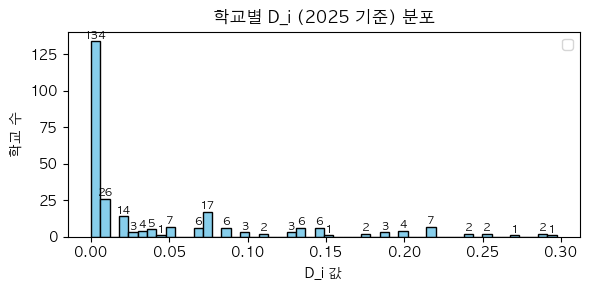

In [796]:
# inf, -inf, NaN 제거
data = df_result_4['D_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 3))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 D_i (2025 기준) 분포")
plt.xlabel("D_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

In [797]:
m = folium.Map(location=[36.8, 127.7], zoom_start=9)

# 모든 학교에 대해 점 + 반경 원 표시
for idx, row in df_24_schools.iterrows():
    lat = row['new위도']
    lon = row['new경도']
    school_name = row['학교명']
    폐교여부 = row['폐교여부']
    
    # 폐교 여부에 따라 색상 결정
    color = 'red' if 폐교여부 == 'Y' else 'green'
    
    # 반경 원 추가
    folium.Circle(
        location=[lat, lon],
        radius = mean_nearest_distance * 1000,  # m
        color=color,  # 원 테두리 색도 폐교여부에 따라
        fill=True,
        fill_color=color,
        fill_opacity=0.1,  # 연하게
        weight=1
    ).add_to(m)

    # 학교 위치 점 추가
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"{school_name} (폐교여부: {폐교여부})"
    ).add_to(m)

m

## 1.5 전체학생수 ($X_i$)

In [798]:
df_24_5 = df_24[df_24['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [799]:
df_23_5 = df_23[df_23['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [800]:
df_22_5 = df_22[df_22['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [801]:
# 1. 우선, 각 데이터프레임의 '학교명' 기준으로 병합
df_merge = df_24_5.merge(df_23_5, on='학교명', how='inner', suffixes=('_2024', '_2023'))
df_merge = df_merge.merge(df_22_5, on='학교명', how='inner')

# 2. 컬럼 정리
# df_22_5에는 suffix가 없으니까 추가로 이름을 변경
df_merge = df_merge.rename(columns={
    '지역': '지역_2022',
    '전체학생수(계)': '전체학생수(계)_2022'
})

# 3. 최종 컬럼 구성
df_merge = df_merge[['학교명','전체학생수(계)_2024','전체학생수(계)_2023','전체학생수(계)_2022']]
# 4. 3개년 전체학생수 평균 계산
df_merge['X_i(2025)'] = np.ceil(
    df_merge[['전체학생수(계)_2022', '전체학생수(계)_2023', '전체학생수(계)_2024']].mean(axis=1)
).astype(int)

df_result_5 = df_merge[['학교명', 'X_i(2025)']].sort_values('X_i(2025)')
# df_result_5['X_i(2025)'] = -df_result_5['X_i(2025)']
df_result_5.to_csv(path+'\SCR_data\5-X_i(2025).csv')
df_result_5

,학교명,X_i(2025)
0,가곡초등학교보발분교장,2
1,용원초등학교동락분교장,3
2,영춘초등학교별방분교장,4
5,판동초등학교송죽분교장,6
4,증약초등학교대정분교장,7
...,...,...
263,창리초등학교,1405
261,산성초등학교,1435
259,각리초등학교,1442
265,중앙초등학교,1662


In [853]:
df_merge[df_merge['학교명'].str.contains('')].sort_values('X_i(2025)')[:30]

,학교명,전체학생수(계)_2024,전체학생수(계)_2023,전체학생수(계)_2022,X_i(2025)
0,가곡초등학교보발분교장,1.0,2.0,3.0,2
1,용원초등학교동락분교장,2.0,6.0,0.0,3
2,영춘초등학교별방분교장,5.0,6.0,0.0,4
5,판동초등학교송죽분교장,7.0,10.0,0.0,6
4,증약초등학교대정분교장,6.0,7.0,6.0,7
3,미원초등학교금관분교장,5.0,8.0,12.0,9
9,한송초등학교,15.0,12.0,12.0,13
8,회남초등학교,15.0,12.0,15.0,14
7,산외초등학교,12.0,15.0,16.0,15
6,수산초등학교,11.0,15.0,21.0,16


## 1.6 df_result_1, df_result_2, df_result_3, df_result_4,외부조인

In [804]:
# ✅ 첫 번째 병합 (df_result_1 + df_result_2)
df_merge_1_2 = pd.merge(
    df_result_1,
    df_result_2,
    on=['지역', '학교명'],
    how='outer'
)

# ✅ 두 번째 병합 (df_merge_1_2 + df_result_4)
df_merge_1_2_4 = pd.merge(
    df_merge_1_2,
    df_result_4,
    on=['지역', '학교명'],
    how='outer'
)

df_merge_1_2_4['지역'] = df_merge_1_2_4['지역'].replace('충청북도 청원군', '충청북도 청주시')
df_merge_1_2_4

,지역,학교명,S_i(2025),T_i (2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,0.071429
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,0.142857
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,0.142857
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,0.071429
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,0.142857
...,...,...,...,...,...
265,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,0.108108
266,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,0.216216
267,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,0.000000
268,충청북도 충주시,칠금초등학교,0.107447,0.032160,0.243243


In [805]:
# '지역'에서 마지막 단어 추출해서 '행정구역' 컬럼 생성
df_merge_1_2_4['행정구역'] = df_merge_1_2_4['지역'].apply(lambda x: str(x).split()[-1])

# '지역', '학교명'을 기준으로 중복 제거하면서, 결측값을 서로 채워서 합침
df_merge_1_2_4 = df_merge_1_2_4.groupby(['지역', '학교명'], as_index=False).first()

In [806]:
# 병합 (left join)
df_merged_1_2_3_4 = pd.merge(
    df_merge_1_2_4,
    df_result_3,
    on='행정구역',
    how='left'
)

df_merged_1_2_3_4 = df_merged_1_2_3_4.drop('행정구역',axis=1)
df_merged_1_2_3_4 = df_merged_1_2_3_4[['지역','학교명','S_i(2025)','T_i (2025)','B_i(2025)', 'D_i(2025)']]
df_merged_1_2_3_4

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,1.88,0.071429
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,1.88,0.142857
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,1.88,0.142857
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,1.88,0.071429
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,1.88,0.142857
...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,4.48,0.108108
265,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,4.48,0.216216
266,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,4.48,0.000000
267,충청북도 충주시,칠금초등학교,0.107447,0.032160,4.48,0.243243


In [807]:
# 병합 (left join)
df_merged_1_2_3_4_5 = pd.merge(
    df_merged_1_2_3_4,
    df_result_5,
    on='학교명',
    how='left'
)

df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,1.88,0.071429,53.0
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,1.88,0.142857,136.0
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,1.88,0.142857,287.0
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,1.88,0.071429,51.0
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,1.88,0.142857,60.0
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,4.48,0.108108,622.0
265,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,4.48,0.216216,315.0
266,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,4.48,0.000000,995.0
267,충청북도 충주시,칠금초등학교,0.107447,0.032160,4.48,0.243243,390.0


능산초등학교 - df_result_1,df_result_4 에 없음 -> 2023년 3월 1일 폐교   
영춘초등학교별방분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
오송솔미초등학교 - df_result_1, df_result_2 에 없음 -> 2025년 3월 1일 개교   
용원초등학교동락분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
판동초등학교송죽분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   

In [808]:
df_merged_1_2_3_4_5[df_merged_1_2_3_4_5.isnull().any(axis=1)].sort_values('학교명')

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
72,충청북도 음성군,능산초등학교,NaN,0.105263,4.28,NaN,NaN
26,충청북도 단양군,영춘초등학교별방분교장,NaN,0.122222,2.24,0.000000,4.0
193,충청북도 청주시,오송솔미초등학교,NaN,NaN,6.00,0.000000,NaN
253,충청북도 충주시,용원초등학교동락분교장,NaN,0.166667,4.48,0.000000,3.0
39,충청북도 보은군,판동초등학교송죽분교장,NaN,0.047619,2.64,0.133333,6.0


In [809]:
df_merged_1_2_3_4_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   지역          269 non-null    object 
 1   학교명         269 non-null    object 
 2   S_i(2025)   264 non-null    float64
 3   T_i (2025)  268 non-null    float64
 4   B_i(2025)   269 non-null    float64
 5   D_i(2025)   268 non-null    float64
 6   X_i(2025)   267 non-null    float64
dtypes: float64(5), object(2)
memory usage: 14.8+ KB


In [810]:
df_imsi_12345 = df_merged_1_2_3_4_5[df_merged_1_2_3_4_5['X_i(2025)'] <= 40].sort_values('X_i(2025)')
df_imsi_12345[:30]

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
16,충청북도 단양군,가곡초등학교보발분교장,0.444444,0.166667,2.24,0.076923,2.0
253,충청북도 충주시,용원초등학교동락분교장,NaN,0.166667,4.48,0.000000,3.0
26,충청북도 단양군,영춘초등학교별방분교장,NaN,0.122222,2.24,0.000000,4.0
39,충청북도 보은군,판동초등학교송죽분교장,NaN,0.047619,2.64,0.133333,6.0
67,충청북도 옥천군,증약초등학교대정분교장,-0.007937,0.000000,2.76,0.000000,7.0
161,충청북도 청주시,미원초등학교금관분교장,0.125000,0.263889,6.00,0.000000,9.0
110,충청북도 제천시,한송초등학교,-0.194444,-0.066667,4.02,0.000000,13.0
40,충청북도 보은군,회남초등학교,0.089394,0.094444,2.64,0.000000,14.0
31,충청북도 보은군,산외초등학교,0.188949,0.061111,2.64,0.000000,15.0
101,충청북도 제천시,수산초등학교,0.267460,0.074747,4.02,0.000000,16.0


In [811]:
from sklearn.preprocessing import StandardScaler

# ✅ 스케일링 대상 컬럼 지정
scale_cols = ['S_i(2025)', 'T_i (2025)', 'B_i(2025)', 'D_i(2025)', 'X_i(2025)']

# ✅ StandardScaler로 표준화
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_merged_1_2_3_4_5[scale_cols])

# ✅ 결과를 데이터프레임으로 다시 넣기
df_merged_1_2_3_4_5 = df_merged_1_2_3_4_5.copy()
df_merged_1_2_3_4_5[scale_cols] = scaled_values

# ✅ 결과 확인
df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.367178,-0.655046,-1.881878,0.407381,-0.702696
1,충청북도 괴산군,괴산명덕초등학교,0.572723,0.335999,-1.881878,1.439662,-0.477566
2,충청북도 괴산군,동인초등학교,0.341977,-0.095985,-1.881878,1.439662,-0.067993
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.295868,-0.112696,-0.080611,0.937471,0.840663
265,충청북도 충주시,충주중앙초등학교,0.010085,0.142647,-0.080611,2.499843,0.007954
266,충청북도 충주시,충주중앙탑초등학교,-0.417316,-0.266887,-0.080611,-0.624900,1.852390
267,충청북도 충주시,칠금초등학교,0.498982,0.250930,-0.080611,2.890436,0.211385


In [812]:
df_merged_1_2_3_4_5.to_csv(path + '/SCR_data/merged_STBDX(2025).csv')

# 2. 가중치 설정

In [813]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 데이터 준비
X = df_merged_1_2_3_4_5[['S_i(2025)',
                         # 'T_i (2025)',
                         'B_i(2025)',
                         'D_i(2025)',
                         'X_i(2025)'
                         ]].dropna()

# 3. PCA
pca = PCA()
pca.fit(X)

# 4. 첫 번째 주성분(PC1)의 계수 가져오기
pc1_loadings = pca.components_[0]

# 5. 결과 정리
weights = pd.Series(pc1_loadings, index=['S_i(2025)',
                                         # 'T_i(2025)',
                                         'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])
weights = weights / weights.abs().sum()  # 절댓값 기준으로 정규화해도 좋음

print(weights)

S_i(2025)   -0.129052
B_i(2025)    0.384173
D_i(2025)   -0.163150
X_i(2025)    0.323626
dtype: float64


In [814]:
# # 1. PC1, PC2 계수 가져오기
# pc1_loadings = pca.components_[0]
# pc2_loadings = pca.components_[1]

# # 2. 주성분 설명비율 가져오기
# explained_variance = pca.explained_variance_ratio_

# # 3. 비율 가중 합 계산
# combined_loadings = pc1_loadings * explained_variance[0] + pc2_loadings * explained_variance[1]

# # 4. 정리
# weights = pd.Series(combined_loadings, index=['S_i(2025)',
#                                               # 'T_i(2025)',
#                                               'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])
# weights = weights / weights.abs().sum()  # 절댓값 합 1로 정규화 (선택사항)

# print(weights)

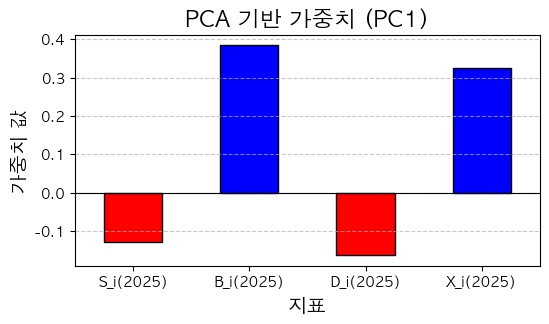

In [815]:
import matplotlib.pyplot as plt

# ✅ 막대그래프 그리기
plt.figure(figsize=(6, 3))
weights.plot(kind='bar', color=['red' if w < 0 else 'blue' for w in weights], edgecolor='black')

# ✅ 세부 설정
plt.title('PCA 기반 가중치 (PC1)', fontsize=16)
plt.xlabel('지표', fontsize=14)
plt.ylabel('가중치 값', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8)  # 기준선
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [816]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cross_decomposition import PLSRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # 1. 데이터 불러오기 (여기서는 예시로 직접 생성한다고 가정)
# # df = pd.read_csv('your_data.csv')
# # X와 Y를 동시에 NaN 기준으로 삭제
# df_merged_1_2_3_4_5 = df_merged_1_2_3_4_5[['S_i(2025)', 'T_i (2025)', 'B_i(2025)', 'D_i(2025)', 'X_i(2025)']].dropna()

# # 2. 필요한 컬럼만 추출
# X = df_merged_1_2_3_4_5[['S_i(2025)', 'T_i (2025)', 'B_i(2025)', 'D_i(2025)']]
# Y = df_merged_1_2_3_4_5[['X_i(2025)']]  # 타겟은 2D (column vector)로 유지

# # 3. 표준화
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# X_scaled = scaler_X.fit_transform(X)
# Y_scaled = scaler_Y.fit_transform(Y)

# # 4. 데이터 분할 (optional, 학습/테스트 분리)
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# # 5. PLS 모델 학습
# pls = PLSRegression(n_components=2)  # n_components는 1~4 사이에서 결정할 수 있음
# pls.fit(X_train, Y_train)

# # 6. 예측
# Y_pred = pls.predict(X_test)

# # 7. 평가
# mse = mean_squared_error(Y_test, Y_pred)
# print(f"테스트 데이터 MSE: {mse:.4f}")

# # 8. 가중치 확인
# print("PLS 가중치 (x_weights_):")
# print(pls.x_weights_)

In [817]:
df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.367178,-0.655046,-1.881878,0.407381,-0.702696
1,충청북도 괴산군,괴산명덕초등학교,0.572723,0.335999,-1.881878,1.439662,-0.477566
2,충청북도 괴산군,동인초등학교,0.341977,-0.095985,-1.881878,1.439662,-0.067993
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.295868,-0.112696,-0.080611,0.937471,0.840663
265,충청북도 충주시,충주중앙초등학교,0.010085,0.142647,-0.080611,2.499843,0.007954
266,충청북도 충주시,충주중앙탑초등학교,-0.417316,-0.266887,-0.080611,-0.624900,1.852390
267,충청북도 충주시,칠금초등학교,0.498982,0.250930,-0.080611,2.890436,0.211385


In [890]:
# ✅ SCR 계산
df_scr = df_merged_1_2_3_4_5.copy()

# Null 없는 행만 계산
df_scr = df_scr.dropna(subset=['S_i(2025)', 'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])

# 가중치 직접 지정
weight_X = -0.75
weight_S = 0.12
weight_B = -0.05
weight_D = 0.08

# SCR 공식 적용
df_scr['SCR(2025)'] = (
    df_scr['S_i(2025)'] * weight_S +
    df_scr['B_i(2025)'] * weight_B +
    df_scr['D_i(2025)'] * weight_D +
    df_scr['X_i(2025)'] * weight_X
)

# ✅ 결과 정렬
df_scr = df_scr.sort_values('SCR(2025)', ascending=False)

# 결과 출력
df_scr

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025)
16,충청북도 단양군,가곡초등학교보발분교장,2.273525,1.556843,-1.632472,0.486787,-0.841028,1.024161
56,충청북도 옥천군,군남초등학교,0.327439,-0.203591,-1.272219,3.504224,-0.670147,0.885852
35,충청북도 보은군,수한초등학교,0.173282,0.066880,-1.355354,2.265487,-0.767794,0.845646
37,충청북도 보은군,탄부초등학교,-0.063675,-0.144412,-1.355354,2.265487,-0.794918,0.837554
68,충청북도 옥천군,청산초등학교,1.270102,-0.473208,-1.272219,0.407381,-0.762369,0.820390
...,...,...,...,...,...,...,...,...
135,충청북도 청주시,각리초등학교,0.281321,0.073032,0.972437,-0.478921,3.064835,-2.351803
174,충청북도 청주시,산성초등학교,0.018631,-0.046731,0.972437,-0.478921,3.045848,-2.369086
216,충청북도 청주시,창리초등학교,-0.545288,0.354187,0.972437,-0.624900,2.964476,-2.387405
212,충청북도 청주시,중앙초등학교,0.054793,0.000744,0.972437,-0.624900,3.661564,-2.838212


In [891]:
df_scr.to_csv(path+'SCR_data/SCR_result.csv')

In [899]:
# 1. 상위 5%와 15% 커트라인 계산
upper_5 = df_scr['SCR(2025)'].quantile(0.95)
upper_15 = df_scr['SCR(2025)'].quantile(0.85)

# 2. 새로운 컬럼 생성: 초기값은 '안전'
df_scr['폐교위험등급'] = '안전'

# 3. 조건에 따라 '주의'와 '위험' 레이블링
df_scr.loc[(df_scr['SCR(2025)'] >= upper_15) & (df_scr['SCR(2025)'] < upper_5), '폐교위험등급'] = '주의'
df_scr.loc[df_scr['SCR(2025)'] >= upper_5, '폐교위험등급'] = '위험'

In [909]:
df_scr.to_csv(path+'/SCR_data/SCR_result_rank.csv')

In [902]:
len(df_scr[df_scr['폐교위험등급'] == '위험'].sort_values('SCR(2025)', ascending=False))

14

In [904]:
df_scr[df_scr['폐교위험등급'] == '주의'].sort_values('SCR(2025)', ascending=False)

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025),폐교위험등급
50,충청북도 영동군,용화초등학교,0.903963,0.046925,-1.008957,-0.624900,-0.786780,0.699017,주의
24,충청북도 단양군,어상천초등학교,0.648014,1.601771,-1.632472,-0.624900,-0.781356,0.695410,주의
47,충청북도 영동군,양강초등학교,0.376187,0.351894,-1.008957,0.407381,-0.754232,0.693854,주의
25,충청북도 단양군,영춘초등학교,0.934928,0.337661,-1.632472,-0.624900,-0.727107,0.689154,주의
58,충청북도 옥천군,동이초등학교,-0.328468,-0.558178,-1.272219,1.439662,-0.729820,0.686733,주의
12,충청북도 괴산군,청천초등학교,-0.022981,-0.476225,-1.881878,0.407381,-0.743382,0.681463,주의
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709,0.679890,주의
40,충청북도 보은군,회남초등학교,0.403922,0.855642,-1.355354,-0.624900,-0.808480,0.672606,주의
263,충청북도 충주시,충주예성초등학교,0.265046,0.024621,-0.080611,3.281029,-0.496553,0.670733,주의
44,충청북도 영동군,부용초등학교,0.403182,0.299770,-1.008957,2.471943,-0.493841,0.666966,주의


In [895]:
df_scr[df_scr['폐교위험등급'] == '정상'].sort_values('SCR(2025)', ascending=False)

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025),폐교위험등급
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121,0.615023,정상
7,충청북도 괴산군,소수초등학교,-0.035828,-1.007481,-1.881878,-0.624900,-0.762369,0.611579,정상
250,충청북도 충주시,연수초등학교,0.442541,0.014954,-0.080611,2.499843,-0.472141,0.611229,정상
0,충청북도 괴산군,감물초등학교,-0.367178,-0.655046,-1.881878,0.407381,-0.702696,0.609645,정상
5,충청북도 괴산군,백봉초등학교,-0.569432,-0.013281,-1.881878,0.407381,-0.732532,0.607752,정상
...,...,...,...,...,...,...,...,...,...
135,충청북도 청주시,각리초등학교,0.281321,0.073032,0.972437,-0.478921,3.064835,-2.351803,정상
174,충청북도 청주시,산성초등학교,0.018631,-0.046731,0.972437,-0.478921,3.045848,-2.369086,정상
216,충청북도 청주시,창리초등학교,-0.545288,0.354187,0.972437,-0.624900,2.964476,-2.387405,정상
212,충청북도 청주시,중앙초등학교,0.054793,0.000744,0.972437,-0.624900,3.661564,-2.838212,정상


In [819]:
# X_i(2025)   -0.384
# S_i(2025)   0.129
# B_i(2025)   -0.324
# D_i(2025)   0.163

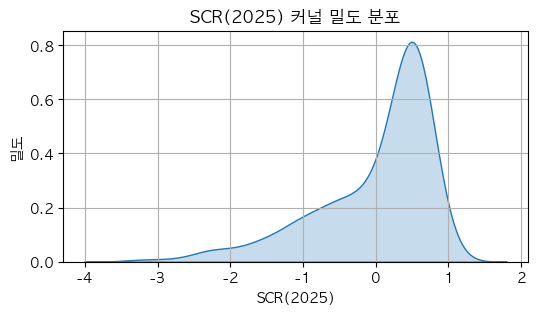

In [905]:
import seaborn as sns

# ✅ KDE 플롯 그리기
plt.figure(figsize=(6,3))
sns.kdeplot(df_scr['SCR(2025)'], fill=True)
plt.title('SCR(2025) 커널 밀도 분포')
plt.xlabel('SCR(2025)')
plt.ylabel('밀도')
plt.grid(True)
plt.show()

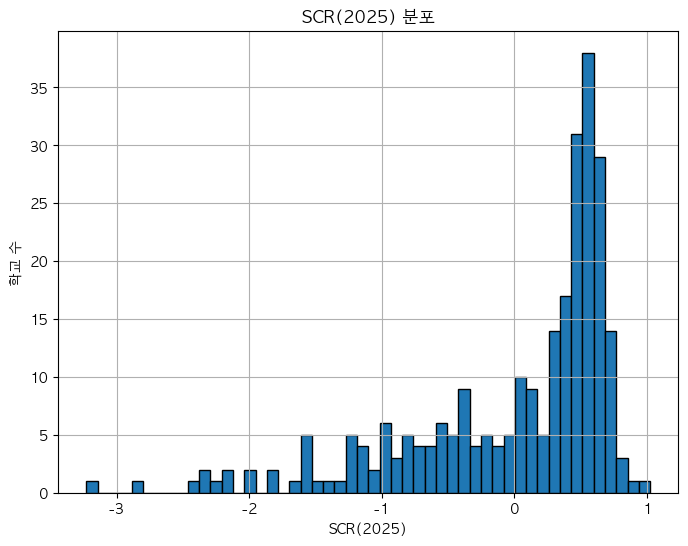

In [906]:
# ✅ 히스토그램 그리기
plt.figure(figsize=(8,6))
plt.hist(df_scr['SCR(2025)'], bins=50, edgecolor='black')
plt.title('SCR(2025) 분포')
plt.xlabel('SCR(2025)')
plt.ylabel('학교 수')
plt.grid(True)
plt.show()

# 3. 폐교는 언제 되었는가?

In [855]:
df_all_school_info = pd.read_csv(path + '학교기본정보(초)_충청북도교육청.csv')
df_all_school_info.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '학교특성',
       '분교여부', '설립유형', '주야구분', '개교기념일', '설립일', '법정동코드', '주소내역', '상세주소내역',
       '우편번호', '학교도로명 우편번호', '학교도로명 주소', '학교도로명 상세주소', '위도', '경도', '전화번호',
       '팩스번호', '홈페이지 주소', '남녀공학 구분', '폐교여부', '폐교일자', '휴교여부'],
      dtype='object')

In [862]:
# '남신초등학교덕생분교장'의 폐교일자 결측값을 20220301로 수정
df_all_school_info.loc[
    (df_all_school_info['학교명'] == '남신초등학교덕생분교장'),
    '폐교일자'
] = 20120301

df_all_school_info[df_all_school_info['폐교여부'] == 'Y'][['지역', '학교명', '분교여부', '폐교여부', '폐교일자']].sort_values('폐교일자')

,지역,학교명,분교여부,폐교여부,폐교일자
237,충청북도 충주시,엄정초등학교목계분교장,Y,Y,20090301.0
8,충청북도 괴산군,문광초등학교덕평분교장,Y,Y,20110228.0
150,NaN,남일초등학교두산분교장,Y,Y,20110228.0
171,NaN,외천초등학교,N,Y,20120229.0
77,충청북도 옥천군,이원초등학교지탄분교장,Y,Y,20120301.0
85,충청북도 음성군,남신초등학교덕생분교장,Y,Y,20120301.0
228,충청북도 충주시,노은초등학교수상분교장,Y,Y,20130228.0
11,충청북도 괴산군,보광초등학교화곡분교장,Y,Y,20130301.0
138,NaN,진천삼수초등학교매산분교장,Y,Y,20130301.0
75,충청북도 옥천군,대성초등학교,N,Y,20140301.0


In [864]:
# ✅ 3년 단위 평균 폐교 수 계산

df = df_all_school_info.copy()

# 1. 폐교일자 결측치 제거
df = df.dropna(subset=['폐교일자'])

# 2. 폐교연도 추출
df['폐교연도'] = df['폐교일자'].astype(int) // 10000

# 3. 3년 단위로 그룹핑
df['연도그룹'] = (df['폐교연도'] // 5) * 5

# 4. 그룹별 폐교 학교 수 세기
close_per_group = df.groupby('연도그룹').size()

# 5. 3년 평균 계산
three_year_avg = close_per_group.mean()

# 결과 출력
print(f"3년 단위 평균 폐교 수: {three_year_avg:.2f}개")

3년 단위 평균 폐교 수: 7.25개
